In [6]:
import cv2
import os
import sys
import numpy as np
import warnings
import pickle  
import time
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# --- Import Sklearn Utilities for Preprocessing & Splitting ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split 

# --- Import Feature Extraction Dependencies ---
try:
    from skimage.feature import hog, graycomatrix, graycoprops, local_binary_pattern
    from sklearn.manifold import TSNE 
except ImportError:
    print("Error: scikit-image or TSNE not found. Please install them.")
    sys.exit(1)

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid")
%matplotlib inline

# --- Configuration ---
SOURCE_DATA_PATH = "Rice_Diseases"
TRAIN_DATA_PATH = "Training_Split" 
TEST_DATA_PATH = "Testing_Split"
OUTPUT_FILENAME = "mlp_pipeline.pkl"
RANDOM_SEED = 42

print("All standard libraries and configuration loaded.")

All standard libraries and configuration loaded.


In [ ]:
# --- Import Your From-Scratch MLP (MLP.py must be defined separately) ---
try:
    # Assuming MLP.py is in the current working directory as per your structure
    from disease.MLP import Sequential, Dense, Dropout 
    print("✅ Successfully imported custom MLP classifier (MLP.py).")
except ImportError as e:
    print(f"--- 🛑 IMPORT ERROR ---")
    print(f"Error importing 'Sequential, Dense, Dropout' from 'MLP.py': {e}")
    print("Please ensure 'MLP.py' is in the root project folder.")
    sys.exit(1)


# --- Helper Functions (Corrected to remove tqdm) ---

def create_train_test_folders(source_dir, train_dir, test_dir, split=0.8):
    """Splits images from source_dir into Training and Testing folders."""
    if os.path.exists(train_dir) and os.path.exists(test_dir):
        print(f"Using existing '{train_dir}' and '{test_dir}' folders.")
        return

    print(f"\n--- Creating {split*100}% Train / { (1-split)*100}% Test Split ---")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path): continue
        
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        if not files: continue
            
        train_files, test_files = train_test_split(
            files, 
            train_size=split, 
            shuffle=True, 
            random_state=RANDOM_SEED,
            stratify=[os.path.basename(class_path)] * len(files) 
        )
        
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Copying files without tqdm
        print(f"Copying files for class: {class_name}...")
        for f in files: 
            src = os.path.join(class_path, f)
            if f in train_files:
                shutil.copy(src, os.path.join(train_dir, class_name, f))
            else:
                shutil.copy(src, os.path.join(test_dir, class_name, f))


def extract_hog(img):
    hog_features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True, transform_sqrt=True)
    return hog_features

def extract_glcm_features(img):
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return features

def extract_lbp_features(img):
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 11), 
                             range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6) 
    return hist

def extract_statistical_features(img):
    mean = np.mean(img)
    var = np.var(img)
    skew = np.mean((img - mean)**3) / (np.std(img)**3 + 1e-6)
    kurt = np.mean((img - mean)**4) / (np.std(img)**4 + 1e-6)
    
    hist = np.histogram(img.ravel(), 256, [0,256])[0]
    hist_norm = hist.astype("float") / (hist.sum() + 1e-6)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-6))
    
    return [mean, var, skew, kurt, entropy]

def extract_features_from_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    img = cv2.resize(img, (128, 128))

    hog_f = extract_hog(img)
    glcm_f = extract_glcm_features(img)
    lbp_f = extract_lbp_features(img)
    stat_f = extract_statistical_features(img)

    combined = np.hstack([hog_f, glcm_f, lbp_f, stat_f])
    return combined

def load_dataset(folder_path):
    features, labels = [], []
    
    print(f"Starting feature extraction from: {folder_path}")
    
    class_dirs = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    
    for label in class_dirs:
        subfolder = os.path.join(folder_path, label)
        
        print(f"  Processing class: {label}...")
        
        # Iterating without tqdm
        files = os.listdir(subfolder)
        for file in files: 
            img_path = os.path.join(subfolder, file)
            try:
                feature_vector = extract_features_from_image(img_path)
                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(label)
            except Exception as e:
                continue
                
    return np.array(features), np.array(labels)

✅ Successfully imported custom MLP classifier (MLP.py).


In [8]:
# --- EDA Execution ---

if not os.path.isdir(SOURCE_DATA_PATH):
    print(f"Error: Source data folder '{SOURCE_DATA_PATH}' not found. Please ensure it's uploaded.")
    sys.exit(1)

# 1. Create Split Folders (if they don't exist)
create_train_test_folders(SOURCE_DATA_PATH, TRAIN_DATA_PATH, TEST_DATA_PATH)

# 2. Load and Extract Features (TRAINING DATA ONLY FOR EDA)
print(f"\nLoading and extracting features from '{TRAIN_DATA_PATH}' for EDA...")
start_load = time.time()
X_train, y_train_labels = load_dataset(TRAIN_DATA_PATH)
end_load = time.time()
print(f"\nFeature Extraction Complete. Time: {end_load - start_load:.2f}s")

if len(X_train) == 0:
    print("Error: No features extracted. Cannot proceed with EDA.")
    sys.exit(1)

# 3. Preprocessing for Visualization
le = LabelEncoder()
y_train_num = le.fit_transform(y_train_labels)
class_names = list(le.classes_)
N_CLASSES = len(class_names)
N_RAW_FEATURES = X_train.shape[1]

print("Applying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Run PCA to get top 2 components for scatter plot
pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(X_train_scaled)

# Run PCA on full data for Scree plot (to visualize variance)
pca_full = PCA(n_components=N_RAW_FEATURES) 
pca_full.fit(X_train_scaled) 

# --- EDA Visualizations (V1-V5) ---
print("\n--- Generating Core Feature EDA Visualizations ---")

# V1: Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_labels, order=class_names, palette='viridis')
plt.title('V1. Training Set Class Distribution', fontsize=16)
plt.xlabel('Disease Type', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# V2: PCA Explained Variance (Scree Plot)
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance)

N_COMPONENTS_TRAIN = 120
if N_RAW_FEATURES >= N_COMPONENTS_TRAIN:
    var_at_120 = cumulative_variance[N_COMPONENTS_TRAIN - 1]
    plt.axvline(x=N_COMPONENTS_TRAIN, color='r', linestyle='--', label=f'{N_COMPONENTS_TRAIN} Components ({var_at_120*100:.2f}% Var)')
    plt.axhline(y=0.95, color='g', linestyle=':', label='95% Variance Threshold')
    plt.legend()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('V2. PCA Explained Variance (Scree Plot)', fontsize=16)
plt.grid(True)
plt.show()

# V3: Mean Feature Variance by Group (After Scaling)
var_hog = np.mean(np.var(X_train_scaled[:, :HOG_LEN], axis=0))
var_glcm = np.mean(np.var(X_train_scaled[:, HOG_LEN:HOG_LEN+GLCM_LEN], axis=0))
var_lbp = np.mean(np.var(X_train_scaled[:, HOG_LEN+GLCM_LEN:HOG_LEN+GLCM_LEN+LBP_LEN], axis=0))
var_stats = np.mean(np.var(X_train_scaled[:, HOG_LEN+GLCM_LEN+LBP_LEN:], axis=0))

feature_groups = ['HOG (8100)', 'GLCM (5)', 'LBP (10)', 'STATS (5)']
group_variances = [var_hog, var_glcm, var_lbp, var_stats]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_groups, y=group_variances, palette='mako')
plt.title('V3. Mean Feature Variance by Group (Scaled Data)', fontsize=16)
plt.xlabel('Feature Group', fontsize=12)
plt.ylabel('Mean Variance per Feature', fontsize=12)
plt.show()

# V4: Data Projection onto Top 2 PCA Components (Separability Check)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_train_pca_2[:, 0], y=X_train_pca_2[:, 1],
    hue=y_train_labels,
    hue_order=class_names,
    palette=sns.color_palette("tab10", N_CLASSES),
    s=50, alpha=0.6
)
plt.title('V4. Data Projection onto Top 2 PCA Components', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca_2.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca_2.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
plt.legend(title='Disease Class')
plt.show()

# V5: Top 10 Feature Loadings for Principal Component 1 (Feature Importance Proxy)
component_1_loadings = pca_2.components_[0]
abs_loadings = np.abs(component_1_loadings)
top_10_indices = np.argsort(abs_loadings)[-10:]
top_10_loadings = component_1_loadings[top_10_indices]

def get_feature_label(index):
    if index < HOG_LEN: return f"HOG_{index}"
    if index < HOG_LEN + GLCM_LEN: return f"GLCM_{index - HOG_LEN}"
    if index < HOG_LEN + GLCM_LEN + LBP_LEN: return f"LBP_{index - HOG_LEN - GLCM_LEN}"
    return f"STATS_{index - HOG_LEN - GLCM_LEN - LBP_LEN}"

top_10_labels = [get_feature_label(i) for i in top_10_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_labels, y=top_10_loadings, palette='coolwarm')
plt.title('V5. Top 10 Feature Loadings for Principal Component 1', fontsize=16)
plt.xlabel('Raw Feature Index/Group', fontsize=12)
plt.ylabel('PCA Component 1 Weight (Loadings)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Using existing 'Training_Split' and 'Testing_Split' folders.

Loading and extracting features from 'Training_Split' for EDA...
Starting feature extraction from: Training_Split
  Processing class: Bacterial Blight Disease...
  Processing class: Blast Disease...
  Processing class: Blast Disease...
  Processing class: Brown Spot Disease...
  Processing class: Brown Spot Disease...
  Processing class: False Smut Disease...
  Processing class: False Smut Disease...

Feature Extraction Complete. Time: 2.15s
Applying StandardScaler...

Feature Extraction Complete. Time: 2.15s
Applying StandardScaler...


ValueError: n_components=8120 must be between 0 and min(n_samples, n_features)=132 with svd_solver='full'


Loading and extracting features from 'Testing_Split' for final model training...
Starting feature extraction from: Testing_Split
  Processing class: Bacterial Blight Disease...
  Processing class: Blast Disease...
  Processing class: Brown Spot Disease...
  Processing class: False Smut Disease...
  Processing class: Brown Spot Disease...
  Processing class: False Smut Disease...

--- Training Custom MLP Model (Layers: 512-256-128-64, Epochs=4000, LR=0.005, PCA=120, L2=0.001) ---
Starting MLP training: 4000 epochs, LR=0.005, L2 Lambda=0.001, Clip=1.0

--- Training Custom MLP Model (Layers: 512-256-128-64, Epochs=4000, LR=0.005, PCA=120, L2=0.001) ---
Starting MLP training: 4000 epochs, LR=0.005, L2 Lambda=0.001, Clip=1.0


Training MLP:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 50/4000 | Avg Epoch Cost: 2.6504


Training MLP:   3%|▎         | 109/4000 [00:00<00:18, 212.94it/s]

Epoch 100/4000 | Avg Epoch Cost: 1.7266


Training MLP:   4%|▍         | 153/4000 [00:00<00:18, 209.84it/s]

Epoch 150/4000 | Avg Epoch Cost: 1.4244


Training MLP:   5%|▍         | 196/4000 [00:00<00:19, 196.18it/s]

Epoch 200/4000 | Avg Epoch Cost: 0.9829


Training MLP:   6%|▋         | 260/4000 [00:01<00:18, 204.30it/s]

Epoch 250/4000 | Avg Epoch Cost: 0.9224


Training MLP:   8%|▊         | 305/4000 [00:01<00:17, 211.41it/s]

Epoch 300/4000 | Avg Epoch Cost: 0.8414


Training MLP:   9%|▉         | 350/4000 [00:01<00:16, 215.60it/s]

Epoch 350/4000 | Avg Epoch Cost: 0.6932


Training MLP:  10%|▉         | 396/4000 [00:01<00:16, 221.46it/s]

Epoch 400/4000 | Avg Epoch Cost: 0.5962


Training MLP:  12%|█▏        | 466/4000 [00:02<00:15, 222.93it/s]

Epoch 450/4000 | Avg Epoch Cost: 0.4969


Training MLP:  13%|█▎        | 512/4000 [00:02<00:17, 201.11it/s]

Epoch 500/4000 | Avg Epoch Cost: 0.4149


Training MLP:  14%|█▍        | 556/4000 [00:02<00:16, 207.56it/s]

Epoch 550/4000 | Avg Epoch Cost: 0.2597


Training MLP:  15%|█▌        | 601/4000 [00:02<00:16, 205.88it/s]

Epoch 600/4000 | Avg Epoch Cost: 0.2996


Training MLP:  16%|█▌        | 643/4000 [00:03<00:16, 204.27it/s]

Epoch 650/4000 | Avg Epoch Cost: 0.3245


Training MLP:  18%|█▊        | 706/4000 [00:03<00:16, 204.91it/s]

Epoch 700/4000 | Avg Epoch Cost: 0.2899


Training MLP:  19%|█▉        | 752/4000 [00:03<00:15, 212.86it/s]

Epoch 750/4000 | Avg Epoch Cost: 0.1832


Training MLP:  20%|█▉        | 795/4000 [00:03<00:16, 190.42it/s]

Epoch 800/4000 | Avg Epoch Cost: 0.1754


Training MLP:  22%|██▏       | 861/4000 [00:04<00:15, 206.00it/s]

Epoch 850/4000 | Avg Epoch Cost: 0.1613


Training MLP:  23%|██▎       | 904/4000 [00:04<00:15, 205.73it/s]

Epoch 900/4000 | Avg Epoch Cost: 0.2287


Training MLP:  24%|██▎       | 946/4000 [00:04<00:15, 201.94it/s]

Epoch 950/4000 | Avg Epoch Cost: 0.1329


Training MLP:  25%|██▌       | 1013/4000 [00:04<00:14, 211.25it/s]

Epoch 1000/4000 | Avg Epoch Cost: 0.1098


Training MLP:  26%|██▋       | 1057/4000 [00:05<00:15, 189.56it/s]

Epoch 1050/4000 | Avg Epoch Cost: 0.1831


Training MLP:  28%|██▊       | 1103/4000 [00:05<00:14, 205.93it/s]

Epoch 1100/4000 | Avg Epoch Cost: 0.1100


Training MLP:  29%|██▊       | 1149/4000 [00:05<00:13, 214.85it/s]

Epoch 1150/4000 | Avg Epoch Cost: 0.1708


Training MLP:  30%|███       | 1218/4000 [00:05<00:12, 220.68it/s]

Epoch 1200/4000 | Avg Epoch Cost: 0.1068


Training MLP:  32%|███▏      | 1263/4000 [00:06<00:12, 212.88it/s]

Epoch 1250/4000 | Avg Epoch Cost: 0.1223


Training MLP:  33%|███▎      | 1307/4000 [00:06<00:14, 188.65it/s]

Epoch 1300/4000 | Avg Epoch Cost: 0.1123


Training MLP:  34%|███▍      | 1352/4000 [00:06<00:13, 203.02it/s]

Epoch 1350/4000 | Avg Epoch Cost: 0.0973


Training MLP:  35%|███▍      | 1399/4000 [00:06<00:12, 214.16it/s]

Epoch 1400/4000 | Avg Epoch Cost: 0.0799


Training MLP:  36%|███▌      | 1444/4000 [00:06<00:11, 215.25it/s]

Epoch 1450/4000 | Avg Epoch Cost: 0.0860


Training MLP:  38%|███▊      | 1513/4000 [00:07<00:11, 213.59it/s]

Epoch 1500/4000 | Avg Epoch Cost: 0.0216


Training MLP:  38%|███▊      | 1535/4000 [00:07<00:12, 191.86it/s]

Epoch 1550/4000 | Avg Epoch Cost: 0.2082


Training MLP:  40%|████      | 1606/4000 [00:07<00:11, 214.58it/s]

Epoch 1600/4000 | Avg Epoch Cost: 0.0764


Training MLP:  41%|████▏     | 1652/4000 [00:07<00:10, 220.57it/s]

Epoch 1650/4000 | Avg Epoch Cost: 0.0446


Training MLP:  42%|████▏     | 1699/4000 [00:08<00:10, 225.58it/s]

Epoch 1700/4000 | Avg Epoch Cost: 0.0263


Training MLP:  44%|████▎     | 1745/4000 [00:08<00:10, 219.77it/s]

Epoch 1750/4000 | Avg Epoch Cost: 0.0373


Training MLP:  45%|████▍     | 1790/4000 [00:08<00:11, 191.06it/s]

Epoch 1800/4000 | Avg Epoch Cost: 0.0672


Training MLP:  46%|████▋     | 1854/4000 [00:08<00:10, 200.76it/s]

Epoch 1850/4000 | Avg Epoch Cost: 0.0577


Training MLP:  47%|████▋     | 1898/4000 [00:09<00:10, 208.17it/s]

Epoch 1900/4000 | Avg Epoch Cost: 0.0549


Training MLP:  49%|████▉     | 1968/4000 [00:09<00:10, 199.67it/s]

Epoch 1950/4000 | Avg Epoch Cost: 0.0546


Training MLP:  50%|█████     | 2010/4000 [00:09<00:09, 201.88it/s]

Epoch 2000/4000 | Avg Epoch Cost: 0.1366


Training MLP:  51%|█████▏    | 2056/4000 [00:09<00:09, 212.12it/s]

Epoch 2050/4000 | Avg Epoch Cost: 0.0720


Training MLP:  52%|█████▏    | 2099/4000 [00:10<00:09, 206.17it/s]

Epoch 2100/4000 | Avg Epoch Cost: 0.0216


Training MLP:  54%|█████▎    | 2143/4000 [00:10<00:09, 197.33it/s]

Epoch 2150/4000 | Avg Epoch Cost: 0.0378


Training MLP:  55%|█████▌    | 2211/4000 [00:10<00:08, 210.62it/s]

Epoch 2200/4000 | Avg Epoch Cost: 0.0192


Training MLP:  56%|█████▋    | 2255/4000 [00:10<00:08, 203.93it/s]

Epoch 2250/4000 | Avg Epoch Cost: 0.1043


Training MLP:  57%|█████▋    | 2297/4000 [00:11<00:08, 190.46it/s]

Epoch 2300/4000 | Avg Epoch Cost: 0.0184


Training MLP:  59%|█████▉    | 2360/4000 [00:11<00:08, 200.82it/s]

Epoch 2350/4000 | Avg Epoch Cost: 0.0523


Training MLP:  60%|██████    | 2403/4000 [00:11<00:08, 193.19it/s]

Epoch 2400/4000 | Avg Epoch Cost: 0.0570


Training MLP:  61%|██████    | 2449/4000 [00:11<00:07, 208.51it/s]

Epoch 2450/4000 | Avg Epoch Cost: 0.0232


Training MLP:  62%|██████▏   | 2493/4000 [00:12<00:07, 194.92it/s]

Epoch 2500/4000 | Avg Epoch Cost: 0.0191


Training MLP:  64%|██████▍   | 2558/4000 [00:12<00:07, 197.52it/s]

Epoch 2550/4000 | Avg Epoch Cost: 0.0240


Training MLP:  64%|██████▍   | 2578/4000 [00:12<00:08, 162.18it/s]

Epoch 2600/4000 | Avg Epoch Cost: 0.0173


Training MLP:  67%|██████▋   | 2667/4000 [00:13<00:06, 201.01it/s]

Epoch 2650/4000 | Avg Epoch Cost: 0.0354


Training MLP:  67%|██████▋   | 2688/4000 [00:13<00:07, 184.76it/s]

Epoch 2700/4000 | Avg Epoch Cost: 0.0243


Training MLP:  69%|██████▉   | 2754/4000 [00:13<00:06, 202.36it/s]

Epoch 2750/4000 | Avg Epoch Cost: 0.0221


Training MLP:  70%|██████▉   | 2797/4000 [00:13<00:06, 191.66it/s]

Epoch 2800/4000 | Avg Epoch Cost: 0.0326


Training MLP:  71%|███████▏  | 2859/4000 [00:14<00:06, 175.60it/s]

Epoch 2850/4000 | Avg Epoch Cost: 0.0292


Training MLP:  73%|███████▎  | 2901/4000 [00:14<00:05, 189.30it/s]

Epoch 2900/4000 | Avg Epoch Cost: 0.0618


Training MLP:  74%|███████▎  | 2942/4000 [00:14<00:05, 184.11it/s]

Epoch 2950/4000 | Avg Epoch Cost: 0.0155


Training MLP:  75%|███████▌  | 3007/4000 [00:14<00:05, 179.55it/s]

Epoch 3000/4000 | Avg Epoch Cost: 0.0392


Training MLP:  76%|███████▌  | 3049/4000 [00:15<00:04, 192.00it/s]

Epoch 3050/4000 | Avg Epoch Cost: 0.0195


Training MLP:  77%|███████▋  | 3090/4000 [00:15<00:04, 182.80it/s]

Epoch 3100/4000 | Avg Epoch Cost: 0.0269


Training MLP:  79%|███████▉  | 3151/4000 [00:15<00:04, 175.48it/s]

Epoch 3150/4000 | Avg Epoch Cost: 0.0169


Training MLP:  80%|███████▉  | 3193/4000 [00:15<00:04, 190.87it/s]

Epoch 3200/4000 | Avg Epoch Cost: 0.1013


Training MLP:  81%|████████▏ | 3251/4000 [00:16<00:04, 167.27it/s]

Epoch 3250/4000 | Avg Epoch Cost: 0.0271


Training MLP:  82%|████████▏ | 3293/4000 [00:16<00:03, 185.25it/s]

Epoch 3300/4000 | Avg Epoch Cost: 0.0845


Training MLP:  84%|████████▍ | 3355/4000 [00:16<00:03, 176.35it/s]

Epoch 3350/4000 | Avg Epoch Cost: 0.0541


Training MLP:  85%|████████▍ | 3398/4000 [00:16<00:03, 190.93it/s]

Epoch 3400/4000 | Avg Epoch Cost: 0.0179


Training MLP:  86%|████████▌ | 3438/4000 [00:17<00:03, 176.60it/s]

Epoch 3450/4000 | Avg Epoch Cost: 0.0243


Training MLP:  88%|████████▊ | 3507/4000 [00:17<00:02, 188.82it/s]

Epoch 3500/4000 | Avg Epoch Cost: 0.0449


Training MLP:  89%|████████▊ | 3548/4000 [00:17<00:02, 182.62it/s]

Epoch 3550/4000 | Avg Epoch Cost: 0.0897


Training MLP:  90%|█████████ | 3605/4000 [00:18<00:02, 170.86it/s]

Epoch 3600/4000 | Avg Epoch Cost: 0.0151


Training MLP:  91%|█████████▏| 3652/4000 [00:18<00:01, 201.38it/s]

Epoch 3650/4000 | Avg Epoch Cost: 0.0357


Training MLP:  92%|█████████▏| 3692/4000 [00:18<00:01, 169.88it/s]

Epoch 3700/4000 | Avg Epoch Cost: 0.0175


Training MLP:  94%|█████████▍| 3756/4000 [00:18<00:01, 175.17it/s]

Epoch 3750/4000 | Avg Epoch Cost: 0.0191


Training MLP:  95%|█████████▍| 3795/4000 [00:19<00:01, 169.52it/s]

Epoch 3800/4000 | Avg Epoch Cost: 0.0190


Training MLP:  96%|█████████▋| 3857/4000 [00:19<00:00, 162.04it/s]

Epoch 3850/4000 | Avg Epoch Cost: 0.0678


Training MLP:  97%|█████████▋| 3892/4000 [00:19<00:00, 156.42it/s]

Epoch 3900/4000 | Avg Epoch Cost: 0.0211


Training MLP:  99%|█████████▉| 3953/4000 [00:20<00:00, 170.22it/s]

Epoch 3950/4000 | Avg Epoch Cost: 0.0510


Training MLP: 100%|██████████| 4000/4000 [00:20<00:00, 196.25it/s]


Epoch 4000/4000 | Avg Epoch Cost: 0.0217

Training Complete. Time: 20.38s

--- Predicting on Test Set ---

--- Evaluation Complete ---
Accuracy: **0.8235**

Classification Report:

                          precision    recall  f1-score   support

Bacterial Blight Disease       0.73      0.89      0.80         9
           Blast Disease       1.00      0.60      0.75         5
      Brown Spot Disease       0.82      0.90      0.86        10
      False Smut Disease       0.89      0.80      0.84        10

                accuracy                           0.82        34
               macro avg       0.86      0.80      0.81        34
            weighted avg       0.84      0.82      0.82        34



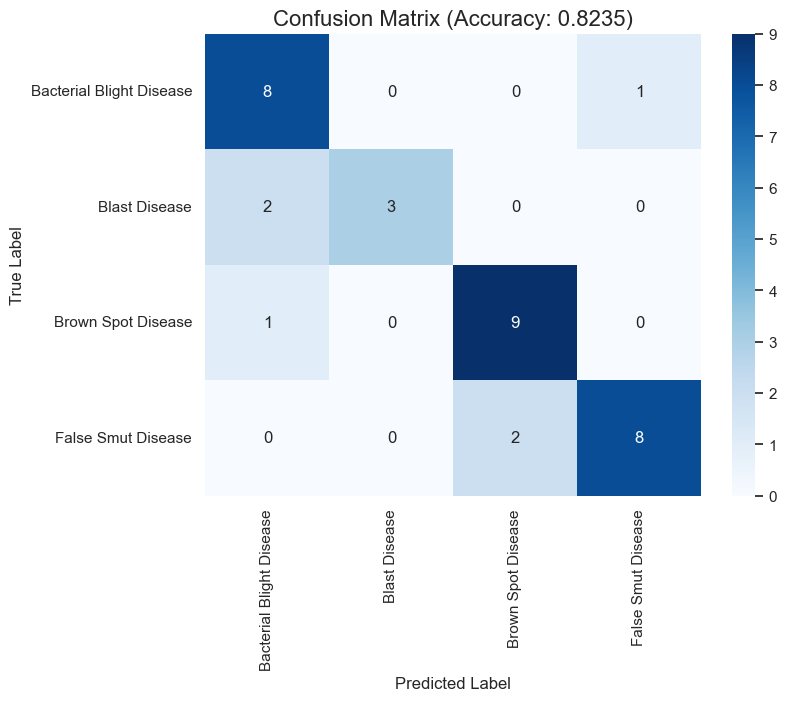


--- Saving Model & Pipeline ---
✅ Successfully saved pipeline components to 'mlp_pipeline.pkl'


In [13]:
# --- Load Test Data and Prepare for Training ---
print(f"\nLoading and extracting features from '{TEST_DATA_PATH}' for final model training...")

# Define the critical hyperparameter variable here for scope safety
N_COMPONENTS_TRAIN = 120 

# Note: X_train_scaled, y_train_num, scaler, le, and class_names must be available
# from the preceding EDA/Preprocessing block.

# Assuming load_dataset(TEST_DATA_PATH) provides X_test and y_test_labels
X_test, y_test_labels = load_dataset(TEST_DATA_PATH)

# Apply Scaler transform using the object fitted on X_train
X_test_scaled = scaler.transform(X_test)
y_test_num = le.transform(y_test_labels)

# --- Final PCA Fit/Transform ---
N_INPUT = N_COMPONENTS_TRAIN

# Create and fit the PCA object (pca) using the training data.
pca = PCA(n_components=N_COMPONENTS_TRAIN)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the fitted pca object.
X_test_pca = pca.transform(X_test_scaled) 

# --- ONE-HOT ENCODING (MANDATORY for Softmax Output) ---
Y_train_one_hot = np.eye(len(class_names))[y_train_num]


# --- 5. Define and Train Custom MLP Classifier (Improved Parameters) ---
LR = 0.005           # Increased LR
EPOCHS = 4000         # Increased epochs
BATCH_SIZE = 128    
L2_LAMBDA = 0.001
CLIP_VALUE = 1.0

print(f"\n--- Training Custom MLP Model (Layers: 512-256-128-64, Epochs={EPOCHS}, LR={LR}, PCA={N_COMPONENTS_TRAIN}, L2={L2_LAMBDA}) ---")
    
# ARCHITECTURE (Wider layers)
model = Sequential(input_shape=N_INPUT) 
model.add(Dense(N_INPUT, 512, activation='relu', lambda_param=L2_LAMBDA))
model.add(Dropout(rate=0.4)) 
model.add(Dense(512, 256, activation='relu', lambda_param=L2_LAMBDA))
model.add(Dropout(rate=0.4)) 
model.add(Dense(256, 128, activation='relu', lambda_param=L2_LAMBDA))
model.add(Dropout(rate=0.4)) 
model.add(Dense(128, 64, activation='relu', lambda_param=L2_LAMBDA))
model.add(Dense(64, len(class_names), activation='softmax', lambda_param=L2_LAMBDA))

start_time = time.time()
# Train model
model.fit(
    X_train_pca, 
    Y_train_one_hot, 
    learning_rate=LR, 
    n_iters=EPOCHS, 
    batch_size=BATCH_SIZE,
    lambda_param=L2_LAMBDA,
    clip_value=CLIP_VALUE
) 
duration = time.time() - start_time
print(f"\nTraining Complete. Time: {duration:.2f}s")


# --- 6. Evaluate ---
print("\n--- Predicting on Test Set ---")
y_pred_num = model.predict(X_test_pca)

accuracy = accuracy_score(y_test_num, y_pred_num)
print("\n--- Evaluation Complete ---")
print(f"Accuracy: **{accuracy:.4f}**") 

print("\nClassification Report:\n")
print(classification_report(y_test_num, y_pred_num, target_names=class_names))

# --- Confusion Matrix Visualization ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_num, y_pred_num)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.4f})', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- 7. Save the Full Pipeline ---
print("\n--- Saving Model & Pipeline ---")
pipeline_components = {
    'model': model,
    'label_encoder': le,
    'scaler': scaler,
    'pca': pca, 
    'class_names': class_names
}

try:
    with open(OUTPUT_FILENAME, 'wb') as f:
        pickle.dump(pipeline_components, f)
    print(f"✅ Successfully saved pipeline components to '{OUTPUT_FILENAME}'")
except Exception as e:
    print(f"--- 🛑 ERROR SAVING MODEL ---")
    print(f"An error occurred: {e}")